Import the necessary libraries

In [ ]:
#for data manupulation
import numpy as np
import pandas as pd

#to handle the date time part of the data
import os.path,time
import datetime

#to plot visualization
import matplotlib.pyplot as plt
#to study the missing values
import missingno as msno

# Preprocessing for normalize data
from sklearn.preprocessing import MinMaxScaler
# Keras Model and Tensorflow
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras import optimizers
from keras.models import Sequential
from keras.utils import plot_model

In [91]:
#getting the dataset
df=pd.read_csv('data.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,5200.899902,5238.450195,5167.100098,5232.200195,5232.200195,0.0
1,2010-01-05,5277.149902,5288.350098,5242.399902,5277.899902,5277.899902,0.0
2,2010-01-06,5278.149902,5310.850098,5260.049805,5281.799805,5281.799805,0.0
3,2010-01-07,5281.799805,5302.549805,5244.750000,5263.100098,5263.100098,0.0
4,2010-01-08,5264.250000,5276.750000,5234.700195,5244.750000,5244.750000,0.0


<Axes: >

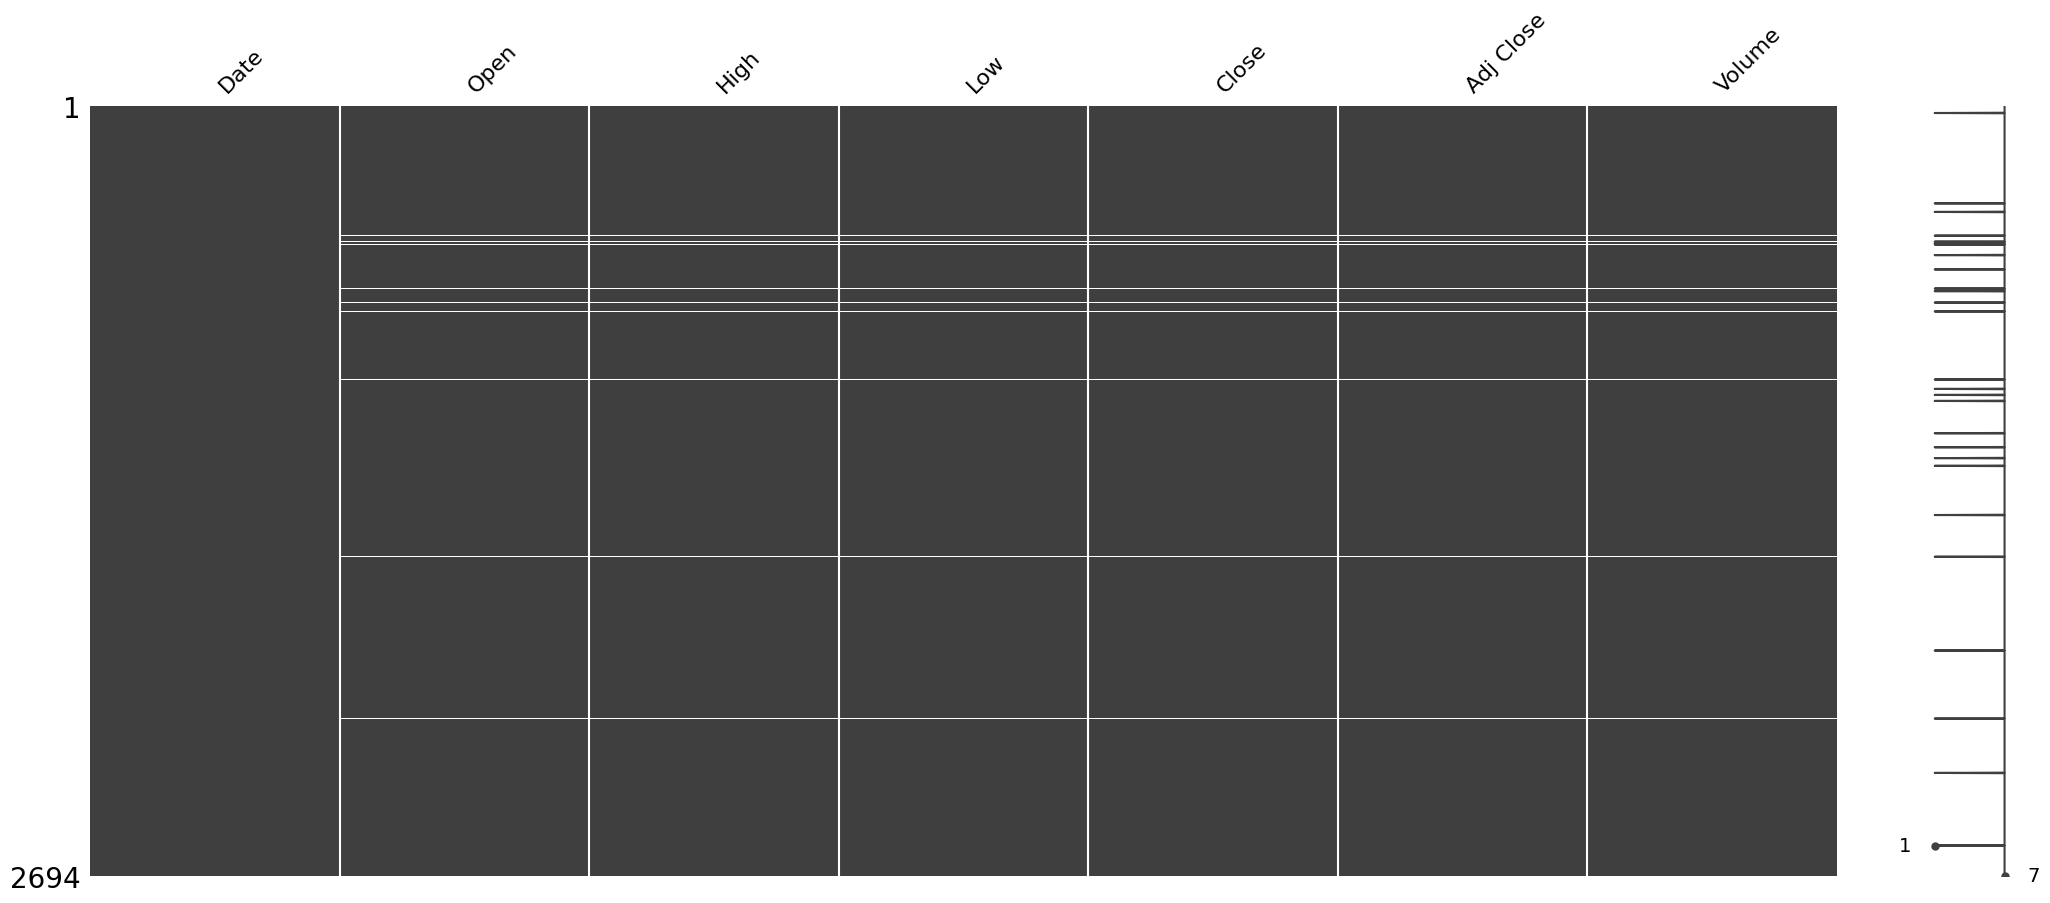

In [92]:
#checking the position of missing values
msno.matrix(df)
#can see that all the columns are empty for the missing rows values

In [93]:
#checking the percentage of missing values
(df.isnull().sum()/df.shape[0])*100
# ~1 percent of missing values in each column

Date         0.000000
Open         1.002227
High         1.002227
Low          1.002227
Close        1.002227
Adj Close    1.002227
Volume       1.002227
dtype: float64

In [94]:
#interpolating the missing values
df=df.interpolate(method='linear',limit_direction='both')

In [95]:
#plotting individual time series
# ax=df.plot.area(colormap='tab20b',figsize=(104,6),subplots=True)
# plt.show()

In [96]:
#drop the close column as we will predict the Adj Close
df=df.drop(['Close','Date'],axis=1)

In [97]:
#normalizing the data to perform in the neural networks
data_normaliser = MinMaxScaler()
y_normaliser = MinMaxScaler()
data_normalised = data_normaliser.fit_transform(df)

In [106]:
history_points = 60
predict_range = 2

# Prepare the data in the format of [day-1-open,day-1-max,day-1-min,...day-history_point ] as 1 row input for predict the 'predict_range' price for train and test
df_histories_normalised = np.array([data_normalised[i  : i + history_points].copy() for i in range(len(data_normalised) - history_points - predict_range +1)])

# Get the actual price [day1-adj close,day2-adj close....day-predict_range adj close] for train and test
next_day_adjclose_values_normalised = np.array([data_normalised[i + history_points:i + history_points + predict_range,3].copy() for i in range(len(data_normalised) - history_points - predict_range+1)])

# Create the same array as the normalised adj close but with the actual value not the scaled down value. This is used to calculate the prediction accuracy
next_day_adjclose_values = np.array([df.iloc[i + history_points:i + history_points+predict_range]['Adj Close'].values.copy() for i in range(len(df) - history_points - predict_range+1)])

# Use the passed normaliser to fit the actual value so that we can scale the predicted result back to actual value
y_normaliser.fit(next_day_adjclose_values)

MinMaxScaler()

In [107]:
#train-test split
def train_test_split(ohlcv_histories, next_day_adj_close, unscaled_y,test_split = 0.2):

    n = int(ohlcv_histories.shape[0] * test_split)

    ohlcv_train = ohlcv_histories[:n]
    y_train = next_day_adj_close[:n]

    ohlcv_test = ohlcv_histories[n:]
    y_test = next_day_adj_close[n:]

    unscaled_y_test = unscaled_y[n:]

    return ohlcv_train, ohlcv_test, y_test, y_train, unscaled_y_test

In [108]:
#running the train-test split function on the data
df_train, df_test, y_test, y_train, unscaled_y_test = train_test_split(df_histories_normalised, next_day_adjclose_values_normalised, next_day_adjclose_values)

Building,training and validating the model

In [109]:
#create a function so that i can change the parameters of the model
def get_LSTM_Model(layer_num, history_points, features_num,predict_range,optimizer,dropout_prob):


    # Initialize LSTM using Keras library
    model = Sequential()
    # Defining hidden layer number and the shape of the input (number of data in the dataset and the number of feature)
    model.add(LSTM(layer_num, input_shape=(history_points, features_num)))

    # Add forget (dropout) layer with probability per argument
    model.add(Dropout(dropout_prob))

    # End the network with hiddenlayer per the size of forecast day e.g. 1,5,10
    model.add(Dense(predict_range))

    # Build and return the model per the selected optimizer
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

In [110]:
# Must be the same as history point that we use to prepare data
history_points = 60
# Must be the same number of features when we prepare data
features_num = 5
predict_range = 2
epoch = 90 #649.3
mode = 'file'
stock='data.csv'
batch_size=40

# LSTM parameters
layer_num = 100
predict_range = 2
optimizer = 'adam'
dropout_prob = 0.3

# Create LSTM model object
model = get_LSTM_Model(layer_num, history_points, features_num,predict_range,optimizer,dropout_prob)

# Parameter for model training
batch_size = 30
epoch = 100
# Train model with our train data
model.fit(x=df_train, y=y_train, batch_size=batch_size, epochs=epoch, shuffle=False, validation_split=0.1,verbose=0)

# The model is train. Test with the test dataset
y_test_predicted = model.predict(df_test)
# Scale up the result to actual value with y_normaliser that we use earlier
y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)

# Calculate the error with MSE
real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test))

print('scaled_mse = ' + str(scaled_mse))

66/66 [==============================] - 3s 12ms/step
scaled_mse = 3.180520810005646


In [112]:
# Visualize the predicted price and the actual price
def display_test_validation_graph(unscaled_y_test, y_test_predicted):

    plt.gcf().set_size_inches(22, 15, forward=True)

    start = 0
    end = -1

    real = plt.plot(unscaled_y_test[start:end], label='real')
    pred = plt.plot(y_test_predicted[start:end], label='predicted')

    plt.legend(['Real', 'Predicted'])

    plt.show()


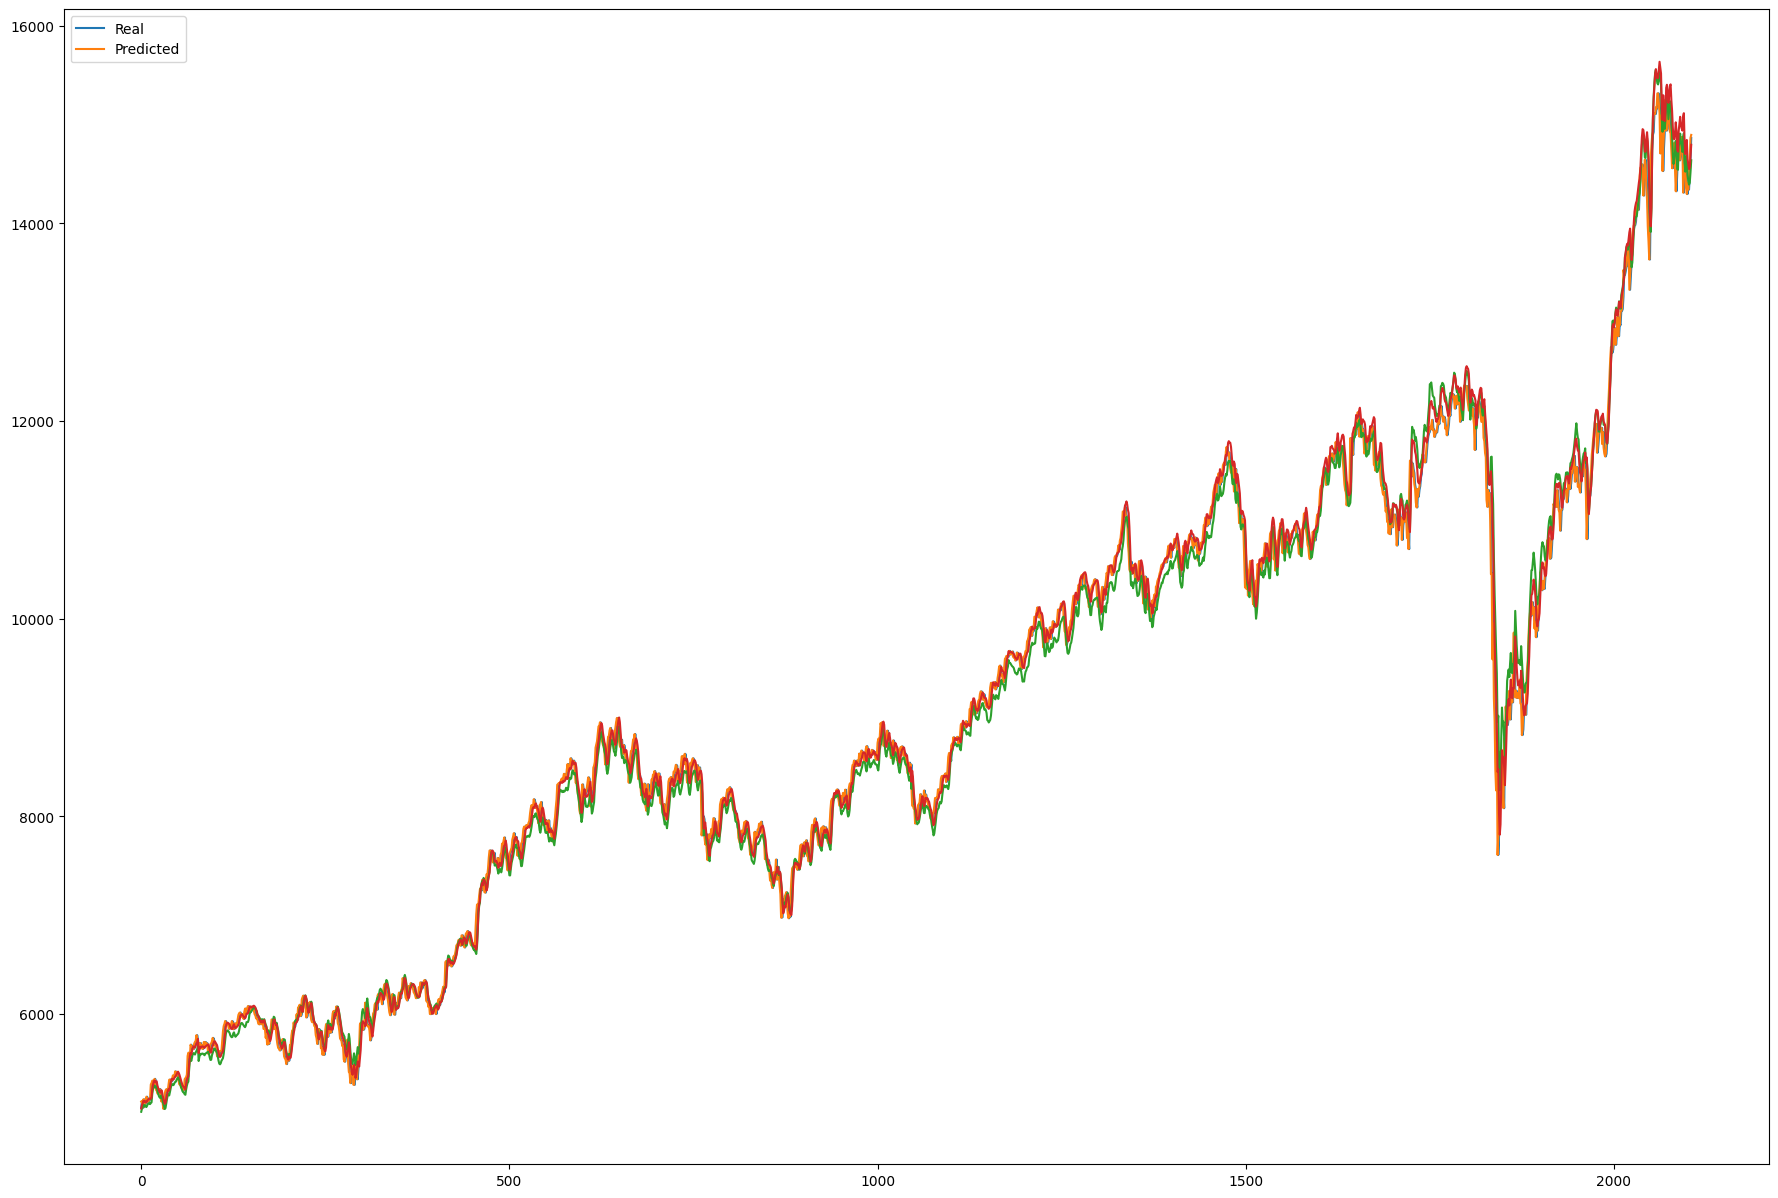

In [111]:
display_test_validation_graph(unscaled_y_test,y_test_predicted)

In [113]:
def dataset_preparation(filename, history_points, predict_range, y_normaliser, mode='file', df=None):

    # Prepare data per mode - file or dataframe input
    if mode=='file':
      # If it is file mode the function expect CSV file path to read the data
      df = pd.read_csv(filename)

    #interpolating the missing values
    df=df.interpolate(method='linear',limit_direction='both')

    # Drop Close as we will predict Adj Close.
    df = df.drop(['Date','Close'],axis=1)

    # Normalise all data to the value range of 0-1 as neural network algorithm has better performance with this data range
    data_normaliser = MinMaxScaler()
    data_normalised = data_normaliser.fit_transform(df)

    # Prepare the data in the format of [day-1-open,day-1-max,day-1-min,...day-history_point ] as 1 row input for predict the 'predict_range' price for train and test
    df_histories_normalised = np.array([data_normalised[i  : i + history_points].copy() for i in range(len(data_normalised) - history_points - predict_range +1)])

    # Get the actual price [day1-adj close,day2-adj close....day-predict_range adj close] for train and test
    next_day_adjclose_values_normalised = np.array([data_normalised[i + history_points:i + history_points + predict_range,3].copy() for i in range(len(data_normalised) - history_points - predict_range+1)])

    # Create the same array as the normalised adj close but with the actual value not the scaled down value. This is used to calculate the prediction accuracy
    next_day_adjclose_values = np.array([df.iloc[i + history_points:i + history_points+predict_range]['Adj Close'].values.copy() for i in range(len(df) - history_points - predict_range+1)])

    # Use the passed normaliser to fit the actual value so that we can scale the predicted result back to actual value
    y_normaliser.fit(next_day_adjclose_values)

    return df_histories_normalised, next_day_adjclose_values_normalised, next_day_adjclose_values, y_normaliser

def train_predictor(df_train,y_train,df_test,y_normaliser,unscaled_y_test,hidden_layer,batch_size,epoch,dropout_probability,history_points,features_num,predict_range):

    # Build model
    model = get_LSTM_Model(hidden_layer,history_points,features_num,predict_range,'adam',dropout_probability)
    # Train model with the train data set
    model.fit(x=df_train, y=y_train, batch_size=batch_size, epochs=epoch, shuffle=False, validation_split=0.1,verbose=0)

    # Get the predict result by using test dataset
    y_test_predicted = model.predict(df_test)
    # Scale up the test result
    y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)

    # Calculate the mse
    real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
    scaled_mse = (real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) )* 100

    return model, scaled_mse

def train_and_validate_stock_predictor(stock,history_points,predict_range,hidden_layer,batch_size,epoch,dropout_probability, mode='file'):

    # If mode is file the data will be read from file which is expected to be at the path per gdrive_path definition
    if mode=='file':
        # In this case features number will be 5
        features_num = 5
        # Prepare data
        df_histories, next_day_adj_close, unscaled_y, y_normaliser = dataset_preparation(stock,history_points,predict_range,MinMaxScaler())

    # Split train and test data
    df_train, df_test, y_test, y_train, unscaled_y_test = train_test_split(df_histories,next_day_adj_close,unscaled_y)

    # Build, train, test and return mode and MSE
    model, scaled_mse = train_predictor(df_train,y_train,df_test,y_normaliser,unscaled_y_test,hidden_layer,batch_size,epoch,dropout_probability,history_points,features_num,predict_range)
    return model, scaled_mse


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
gdrive_path = '/content/drive/My Drive/Colab Notebooks/Data/'
stock='data.csv'

In [114]:
# # 1st Round run all get best parameter function to find the best performer
# predict_range = 2
# max_hidden_layer = 100
# max_history_points = 100
# max_batch_size = 100
# #max_epoch = 100


# get_best_hidden_layer(predict_range, max_hidden_layer,stock)
# get_best_history_points(predict_range, max_history_points,stock)
# get_best_batch_size(predict_range, max_batch_size, stock)
# get_best_dropout_prob(predict_range, stock)  #0.1
# #get_best_epoch(predict_range, max_epoch) #10

In [115]:
# # 2nd Round run all get best parameter function to find the best performer
# #drop_prob=0.1
# predict_range = 2
# max_hidden_layer = 100
# max_history_points = 100
# max_batch_size = 100
# #max_epoch = 100
# stock='data.csv'
# mode='file'

# batch_size=40 #3676


# get_best_hidden_layer(predict_range,max_hidden_layer,stock,batch_size=30)
# get_best_history_points(predict_range, max_history_points,stock,batch_size=30)
# #get_best_batch_size(predict_range,max_batch_size,stock,history_points=history_points)
# get_best_dropout_prob(predict_range,stock,batch_size=30)
# #get_best_epoch(predict_range, max_epoch)

In [116]:
# # 3rd Round run all get best parameter function to find the best performer
# #drop_prob=0.1
# predict_range = 2
# max_hidden_layer = 100
# max_history_points = 100
# max_batch_size = 100
# #max_epoch = 100
# stock='data.csv'
# mode='file'

# batch_size=40
# hidden_layer=100 #1771

# #get_best_hidden_layer(predict_range,max_hidden_layer,stock,history_points=history_points)
# get_best_history_points(predict_range, max_history_points,stock,hidden_layer=hidden_layer,batch_size=batch_size)
# #get_best_batch_size(predict_range,max_batch_size,stock,hidden_layer=hidden_layer,batch_size=batch_size)
# get_best_dropout_prob(predict_range,stock,hidden_layer=hidden_layer,batch_size=batch_size)
# #get_best_epoch(predict_range, max_epoch)

In [117]:
# # 4th Round run all get best parameter function to find the best performer
# #drop_prob=0.1
# predict_range = 2
# max_hidden_layer = 100
# max_history_points = 100
# max_batch_size = 100
# max_epoch = 100
# stock='data.csv'
# mode='file'

# batch_size=40
# hidden_layer=100 #1771
# history_points=60 #538

# #get_best_hidden_layer(predict_range,max_hidden_layer,stock,history_points=history_points)
# #get_best_history_points(predict_range, max_history_points,stock,hidden_layer=hidden_layer,batch_size=batch_size)
# #get_best_batch_size(predict_range,max_batch_size,stock,hidden_layer=hidden_layer,batch_size=batch_size)
# get_best_dropout_prob(predict_range,stock,hidden_layer=hidden_layer,history_points=history_points,batch_size=batch_size)
# get_best_epoch(predict_range, max_epoch,hidden_layer=hidden_layer,history_points=history_points,batch_size=batch_size)

In [118]:
# #5th best parameter function to find the best performer
# #drop_prob=0.1
# predict_range = 2
# max_hidden_layer = 100
# max_history_points = 100
# max_batch_size = 100
# max_epoch = 100
# stock='data.csv'
# mode='file'

# batch_size=40
# hidden_layer=100 #1771
# history_points=60 #538
# epoch=90 #240
# drop_probability=0.3

# #get_best_hidden_layer(predict_range,max_hidden_layer,stock,history_points=history_points)
# #get_best_history_points(predict_range, max_history_points,stock,hidden_layer=hidden_layer,batch_size=batch_size)
# #get_best_batch_size(predict_range,max_batch_size,stock,hidden_layer=hidden_layer,batch_size=batch_size)
# get_best_dropout_prob(predict_range,stock,hidden_layer=hidden_layer,history_points=history_points,batch_size=batch_size,epoch=epoch)
# #get_best_epoch(predict_range, max_epoch,hidden_layer=hidden_layer,history_points=history_points,batch_size=batch_size)

In [119]:
# Apply with prediction 2 day
predict_range = 2

history_points = 60
hidden_layer = 100
batch_size = 40
epoch = 90 #240
dropout_probability = 0.3
mode = 'file'

stock='data.csv'

exception_list = []
mse_list = []

try:
  model, scaled_mse = train_and_validate_stock_predictor(stock,history_points,predict_range,hidden_layer,batch_size,epoch,dropout_probability,mode)
  print("Predict {} days for {} with MSE = {}".format(str(predict_range),str(stock),str(scaled_mse)))
  mse_list.append([stock,scaled_mse])
  model.save(stock+'_'+'.h5')
except Exception as e:
  print("exception "+str(e)+" on "+stock)
  exception_list.append([predict_range,stock,str(e)])
  pd.DataFrame(exception_list).to_csv('/content/drive/My Drive/Colab Notebooks/Data/exception.csv')

66/66 [==============================] - 1s 12ms/step
Predict 2 days for data.csv with MSE = 392.1652483493137


In [87]:
from keras.utils import plot_model
from keras.models import load_model

In [104]:
#parameters
date_range=2
history_points = 60
hidden_layer = 100
batch_size = 40
epoch = 90
dropout_probability = 0.3
mode = 'file'
input=pd.read_csv('sample_input.csv')
model = load_model(stock+'_'+'.h5')

In [105]:
ohlcv_histories, next_day_adj_close, unscaled_y, y_normaliser = dataset_preparation(stock,history_points,predict_range,MinMaxScaler(),mode='file')

adj_predicted = model.predict(ohlcv_histories[len(ohlcv_histories)-1:])
adj_predicted = y_normaliser.inverse_transform(adj_predicted)

print(stock+' price prediction : ' +str(adj_predicted[0][:2]))

1/1 [==============================] - 0s 331ms/step
data.csv price prediction : [14534.133 14509.806]
